In [1]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape=(150,150,3))

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
import os 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = 'f:/data/dogs-vs-cats_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# 객체 생성
datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    # 이미지 변형
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)
    

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
train_features = np.reshape(train_features, (2000, 4*4*512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4*4*512))

---

In [ ]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(weights = 'imagenet',
                  include_top = False,
                  input_shape=(150,150,3))

In [3]:
from tensorflow.keras import models, layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [4]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


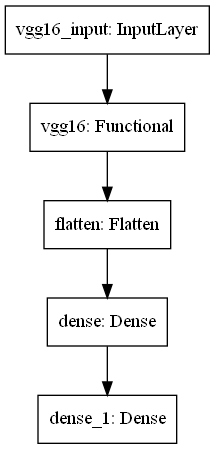

In [6]:
from tensorflow.keras.utils import plot_model

plot_model(model)

In [8]:
len(model.trainable_weights)
# conv_base를 동결하기 전 훈련되는 가중치의 수 : 30 
conv_base.trainable = False
len(model.trainable_weights)
# conv_base를 동결하기 전 훈련되는 가중치의 수 : 4

4

In [13]:
import tensorflow as tf

tf.debugging.set_log_device_placement(True)

In [14]:
import os 
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers

base_dir = 'f:/data/dogs-vs-cats_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255) # 검증 데이터는 증식되어서는 안된다.

train_generator = train_datagen.flow_from_directory(
    train_dir, # 타깃 디렉터리
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir, # 타깃 디렉터리
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/30
100/100 - 113s - loss: 0.4841 - accuracy: 0.8035 - val_loss: 0.3965 - val_accuracy: 0.8460
Epoch 2/30
100/100 - 21s - loss: 0.3840 - accuracy: 0.8390 - val_loss: 0.3341 - val_accuracy: 0.8630
Epoch 3/30
100/100 - 22s - loss: 0.3456 - accuracy: 0.8580 - val_loss: 0.3178 - val_accuracy: 0.8680
Epoch 4/30
100/100 - 21s - loss: 0.3203 - accuracy: 0.8695 - val_loss: 0.2857 - val_accuracy: 0.8840
Epoch 5/30
100/100 - 21s - loss: 0.3014 - accuracy: 0.8765 - val_loss: 0.2722 - val_accuracy: 0.8900
Epoch 6/30
100/100 - 21s - loss: 0.2962 - accuracy: 0.8805 - val_loss: 0.2629 - val_accuracy: 0.8950
Epoch 7/30
100/100 - 21s - loss: 0.2762 - accuracy: 0.8910 - val_loss: 0.2559 - val_accuracy: 0.8970
Epoch 8/30
100/100 - 20s - loss: 0.2740 - accuracy: 0.8870 - val_loss: 0.2502 - val_accuracy: 0.8980
Epoch 9/30
100/100 - 20s - loss: 0.2669 - accuracy: 0.8900 - val_loss: 0.2487 - val_accuracy: 0.9020
Epoch 

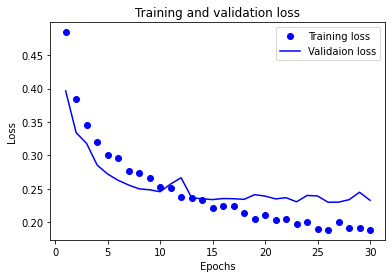

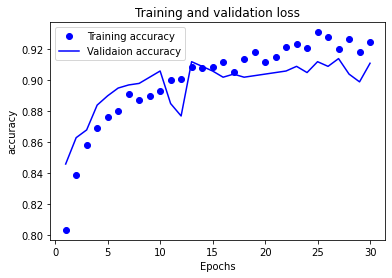

In [15]:
# 훈련의 정확도와 손실 그래프 그리기
import matplotlib.pyplot as plt

history.history.keys()
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaion loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validaion accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [16]:
model.save('f:/data/dogs-vs-cats/cats_and_dogs_small_3.h5')

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
conv_base.layers

In [20]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [23]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 2048GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=2048)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

Virtual devices cannot be modified after being initialized


In [24]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=100,
    validation_data=validation_generator,
    validation_steps=50
)

Epoch 1/100
100/100 [==============================] - 22s 206ms/step - loss: 0.1463 - accuracy: 0.9439 - val_loss: 0.2253 - val_accuracy: 0.9130
Epoch 2/100
100/100 [==============================] - 20s 204ms/step - loss: 0.1143 - accuracy: 0.9590 - val_loss: 0.2157 - val_accuracy: 0.9220
Epoch 3/100
100/100 [==============================] - 20s 203ms/step - loss: 0.0993 - accuracy: 0.9690 - val_loss: 0.2620 - val_accuracy: 0.9080
Epoch 4/100
100/100 [==============================] - 21s 210ms/step - loss: 0.0828 - accuracy: 0.9683 - val_loss: 0.2259 - val_accuracy: 0.9140
Epoch 5/100
100/100 [==============================] - 20s 204ms/step - loss: 0.0718 - accuracy: 0.9723 - val_loss: 0.2253 - val_accuracy: 0.9190
Epoch 6/100
100/100 [==============================] - 22s 214ms/step - loss: 0.0689 - accuracy: 0.9768 - val_loss: 0.2174 - val_accuracy: 0.9230
Epoch 7/100
100/100 [==============================] - 18s 178ms/step - loss: 0.0655 - accuracy: 0.9738 - val_loss: 0.2540 -

In [ ]:
# 훈련의 정확도와 손실 그래프 그리기
import matplotlib.pyplot as plt

history.history.keys()
# dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validaion loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validaion accuracy')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

In [ ]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(accuracy), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_accuracy), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.figure()

In [ ]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=20,
    class_mode='binary'
)

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)